# Lab 8 Regression (Python for GPGN536)

## Name: Anastasia Horne

## Student Number: 10867499

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Q1 Fitting exponential curves
Because the decay of hydrocarbon production of a single well is usually follow an exponential decay, it is very common to fit an exponential curve if you work for oil industry. "production.csv" contains about 100 days of the production data from an oil producer. Please fit the data with following formula:
$$
p = A e^{\alpha t}
$$
where $A$ and $\alpha$ are the unknowns to be inverted using least square regression.

1. Transfer the equation to linear form.
2. Calculate the value of A and $\alpha$.
3. Calculate the production prediction of well for three years.
4. Plot the predicted curve on top of the data.
5. Analytically calculate the total production of the well through its life time.


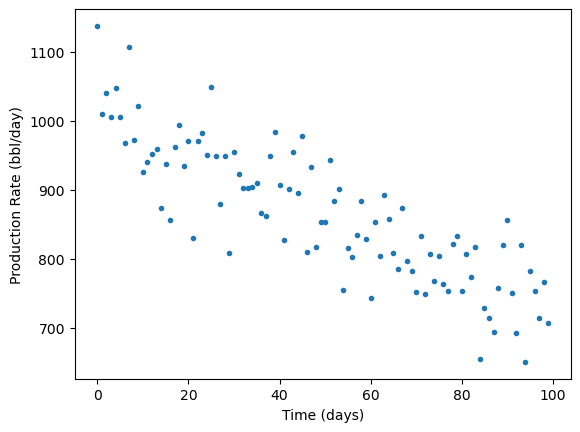

In [5]:
# read in the data
df = pd.read_csv('production.csv')
t = df['Day'].values.flatten()
p = df['Production bbl/day'].values.flatten()

# plot the data
plt.figure()
plt.plot(t,p,'.')
plt.xlabel('Time (days)')
plt.ylabel('Production Rate (bbl/day)')
plt.show()


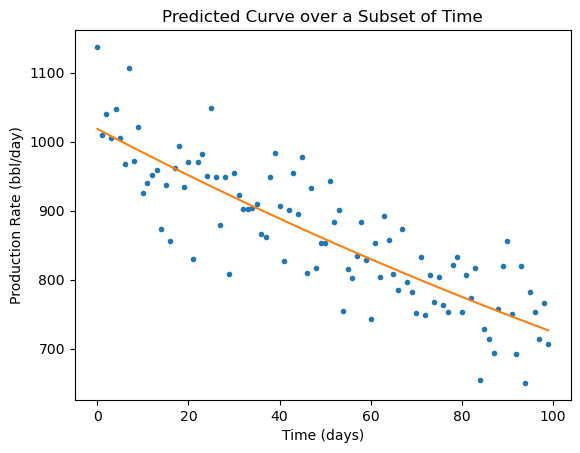

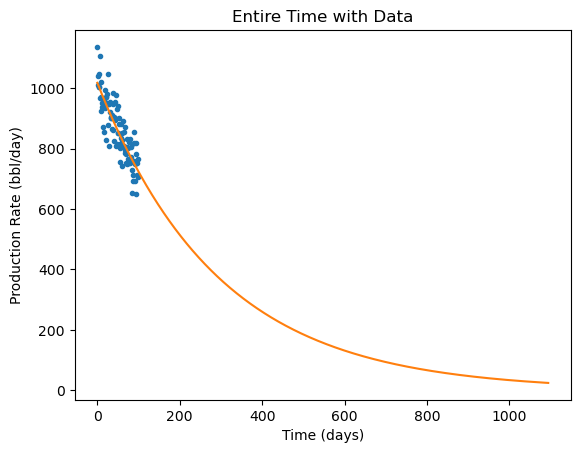

The total production of the well through its life time is: 291242.25562379544 bbl.
Predicted A value: 1018.3597265111416
Predicted alpha value: -0.003413350255321801


In [6]:
#Transfer the equation to linear form. (ln(p)=ln(A)+alpha*t) = (Y=b+alpha*t)
y= np.log(p)

#Calculate the value of A and Alpha
A = np.hstack((t.reshape(-1,1),np.ones(len(t)).reshape(-1,1)))
A_dagger = A.T.dot(A)
para = np.linalg.inv(A_dagger).dot(A.T.dot(y))
b= para[1]
alpha=para[0]

A_para= np.exp(b)
#Calculate the production prediction of well for three years.
time= np.arange(0,365*3,1)
p_pred= A_para*np.exp(alpha*time)

#Plot the predicted curve on top of the data. (wasnt sure what time scale you wanted us to use)
plt.figure()
plt.plot(t,p,'.', label="Data")
plt.plot(t, p_pred[0:len(t)], label="Predicted Curve")
plt.xlabel('Time (days)')
plt.ylabel('Production Rate (bbl/day)')
plt.title("Predicted Curve over a Subset of Time")
plt.show()

plt.figure()
plt.plot(t,p,'.', label="Data")
plt.plot(time, p_pred, label="Predicted Curve")
plt.xlabel('Time (days)')
plt.ylabel('Production Rate (bbl/day)')
plt.title("Entire Time with Data")
plt.show()

#Analytically calculate the total production of the well through its life time.
#integrate our function: (A/alpha)* e^(alpha*T) - (A/alpha)* e^(alpha*0) 
total_prod= (A_para/alpha)*np.exp(alpha*1095) - (A_para/alpha)*1
print("The total production of the well through its life time is:", total_prod, "bbl.")
alpha_para=alpha
print("Predicted A value:", A_para)
print("Predicted alpha value:", alpha_para)

# Q2 Fitting a smooth curve

A common practice to fit a noisy time series data with unknown form to use a piece-wise interpolation (smooth curve) to fit the data. As discussed during the class, piecewise interpolation can be presented as a matrix form, since each data can be presented by a linear summation of several control points.

As shown in the following example, by having 100 control points, we can generate a curve to fit the data, but the curve is not as smooth as we wanted.

We can add smoothness constraint on the control points, which requires the difference between the nearby control points to be small. The inversion problem can be written as:
$$
A^* =
\begin{bmatrix}
A \\ \alpha\Gamma
\end{bmatrix}, \ \ \
b^* =
\begin{bmatrix}
b \\ \alpha \gamma
\end{bmatrix}\\
A^{*T}A^* x = A^{*T}b^*
$$
where
$$
\Gamma =
\begin{bmatrix}
1 & -1 & 0 & 0 & \dots & 0& 0 \\
0 & 1 & -1 & 0 & \dots & 0& 0 \\
0 & 0 & 1 & -1 & \dots & 0& 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 1 & -1 \\
\end{bmatrix}, \ \ \ \
\gamma =
\begin{bmatrix}
0 \\ 0 \\0 \\ \vdots \\ 0
\end{bmatrix}
$$

1. Generate regularization matrix
2. Perform regulated least square inversion
3. Calculate error between the data (y) and model prediction.
4. Calculate error between inverted model and true model at data locations.
5. Plot how these two errors changes with alpha (weight of regularization)

In [9]:
from scipy.interpolate import interp1d
def interp_to_matrix(x0,x,kind='cubic'):
    ''' Function convert interpolation from grid location x0 to data location x to an interpolation matrix
    so that interp1d(x0,y0)(x) is equivalent to A.dot(y0)
    FYI: this is a very slow algorithm for the coding easiness.
    usage: A = interp_to_matrix(x0,x)
    input:
        x0: interpolation control point location, (n,) array
        x: data point location, (m,) array
    output:
        matrix A with shape (m,n)
    written by Ge Jin, gjin@mines.edu, 09/2019
    '''
    A = np.zeros((len(x),len(x0)))
    for i in range(len(x0)):
        y0 = np.zeros(len(x0))
        y0[i] = 1
        f = interp1d(x0,y0,kind=kind,bounds_error=False,fill_value='extrapolation')
        A[:,i] = f(x)

    return A



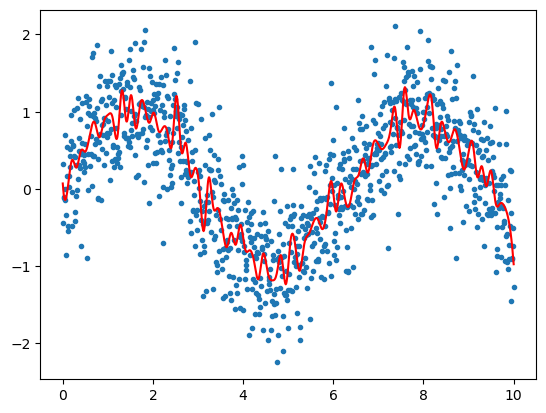

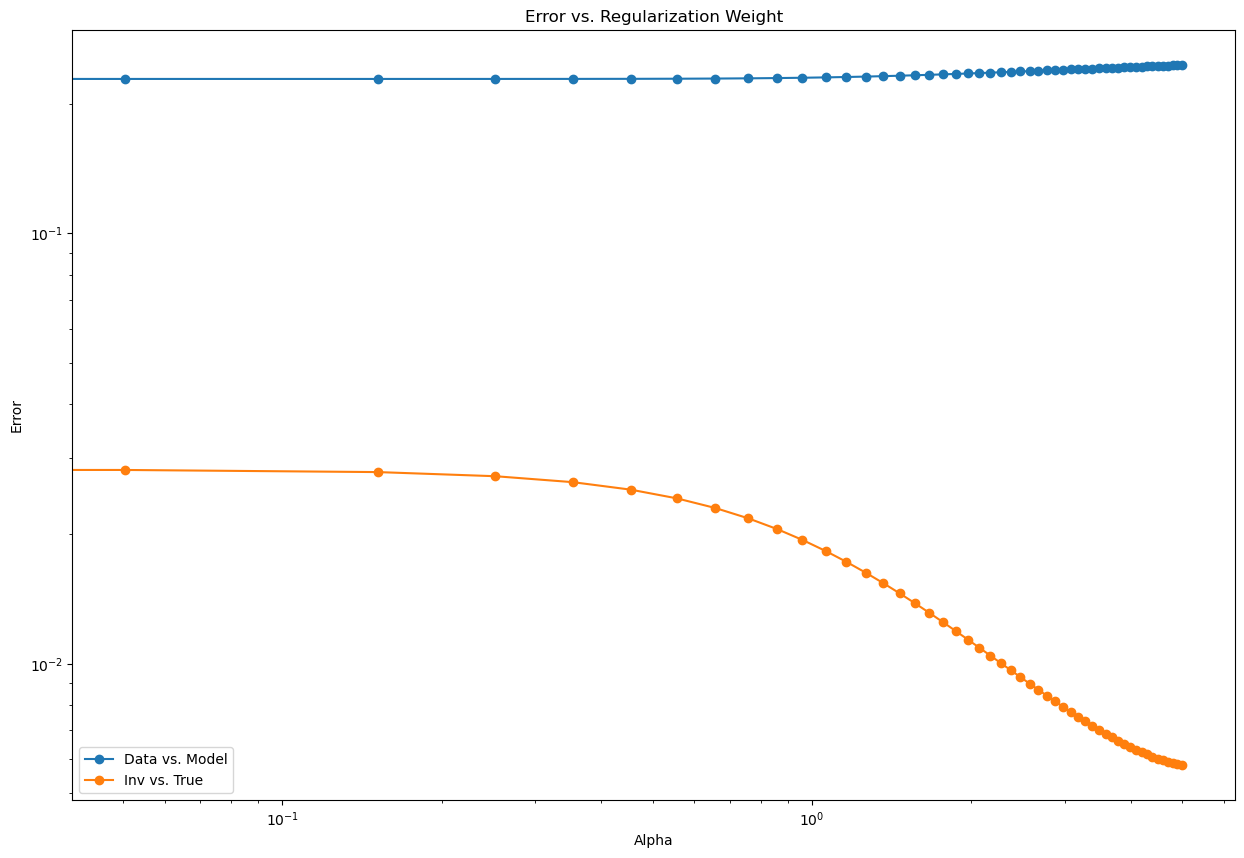

In [10]:
# data set for Q2
x = np.linspace(0,10,1000)
true_y = np.sin(x)
y = np.sin(x) + np.random.normal(0,0.5,1000)

# define control points:
xc = np.linspace(0,10,100)

A = interp_to_matrix(xc,x,kind='cubic')
yc = np.linalg.inv(A.T@A)@A.T@y
y_pred = A@yc

plt.figure()
plt.plot(x,y,'.')
plt.plot(x,y_pred,'r-')
plt.show()

#perform smoothness regulization here
#generate regularization matrix
Gamma = np.zeros((len(xc)-1, len(xc)))
for i in range(len(xc)-1):
    Gamma[i, i] = 1
    Gamma[i, i+1] = -1

#alpha values
alphas = np.linspace(-5, 5, 100)
data_errors = []
model_errors = []

for alpha in alphas:
    #Perform regulated least square inversion
    As = np.vstack([A, alpha * Gamma])
    bs = np.hstack([y, np.zeros(Gamma.shape[0])])

    yc = np.linalg.solve(As.T @ As, As.T @ bs)
    y_pred = A @ yc

    #calculate errors
    data_error = np.mean((y - y_pred) ** 2)
    model_error = np.mean((true_y - y_pred) ** 2)
    data_errors.append(data_error)
    model_errors.append(model_error)

#error curves
plt.figure(figsize=(15,10))
plt.loglog(alphas, data_errors, '-o', label='Data vs. Model')
plt.loglog(alphas, model_errors, '-o', label='Inv vs. True')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.title('Error vs. Regularization Weight')
plt.show()



# Q3: Non-linear Regression
Try to solve the problem in Q1 using non-linear regression with the function's original form. One thing you may notice is that the unknown parameters A and $\alpha$ are in different order of magnitudes. This will generate some instability in all gradient-decent based methods. One trick to do this is to rescale the parameters in the defined function. In this case, we redefine $A'=A/1000$ and $\alpha'=1000\alpha$, and invert for $A'$ and $\alpha'$ instead.

$$
p = 1000A' e^{\frac{1}{1000}\alpha' t}
$$

In the following example you can see that Python has provided a very convenience function to run automated gradient decent for you. However, the minimize function calculate the error function gradient numerically.

1. Calculate analytically the first and second-order gradient of the error function with respect to the model parameter $A'$ and $\alpha'$, which are the $b$ vector and $B$ matrix in the class notebook and powerpoint. Post your analytical expression for $b$ and $B$ using Latex or picture.
2. Use Newton's Method to estimate $A'$ and $\alpha'$ from a reasonable initial model.  
3. Compare your results with linear least square inversion results.

#### 1.

We have the function, $p = 1000A' e^{\frac{1}{1000}\alpha' t}$, and the error function $E=\sum_i(y_i-p(t_i))^2$. The first order gradient error function takes on the form $b=[\frac{\partial E}{\partial A'},\frac{\partial E}{\partial \alpha'}]$. Taking the first partials of our error function with respect to the parameters we get:
\begin{equation}
b = \begin{bmatrix}
 -2000 \sum_i e^{\frac{1}{1000}\alpha't_i}(y_i-p(t_i)) \\
 - 2\sum_i t_iA'e^{\frac{1}{1000}\alpha't_i}(y_i-p(t_i))
\end{bmatrix}
\end{equation}.

The second-order gradient of the error function takes on the form of a $4\times4$ matrix with the second partials of the error function, specifically:
\begin{equation}
B = \begin{bmatrix}
 (2*10^6) \sum_i e^{\frac{\alpha't_i}{500}} & 2 \sum_i t_i(2000A'e^{\frac{\alpha't_i}{500}} - y_ie^{\frac{\alpha't_i}{1000}}) \\
2 \sum_i t_i(2000A'e^{\frac{\alpha't_i}{500}} - y_ie^{\frac{\alpha't_i}{1000}})  & \sum_i t_i^2(4 A'^2 e^{\frac{\alpha't_i}{500}} - \frac{1}{500}A' y_i e^{\frac{\alpha't_i}{1000}})
\end{bmatrix}
\end{equation}.


In [13]:
# read in the data
df = pd.read_csv('production.csv')
t = df['Day'].values.flatten()
p = df['Production bbl/day'].values.flatten()

def errfun(para,t,p):
    A = para[1]*1000
    r = para[0]/1000
    err = np.sum((p-A*np.exp(r*t))**2)
    return err

from scipy.optimize import minimize

opt = minimize(errfun,[-1,0],args=(t,p))
print(opt)
print('inverted parameter:'+str(opt.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 272579.4465447764
        x: [-3.415e+00  1.020e+00]
      nit: 11
      jac: [ 0.000e+00  3.906e-03]
 hess_inv: [[ 9.401e-09 -7.641e-09]
            [-7.641e-09  7.563e-09]]
     nfev: 123
     njev: 37
inverted parameter:[-3.41492808  1.02029604]


In [14]:
#Newton's Method

#initial guesses
A_init = 1.0
alpha_init = 15.0  
params = np.array([A_init, alpha_init])
    
for i in range(150):
    #calculate gradients
    p_pred = 1000 * params[0] * np.exp((params[1] * t)/ 1000)
    
    #First order (b)
    dF_dA = np.exp((params[1]*t)/1000)
    dF_dalpha = params[0] * t * np.exp((params[1]*t)/1000)
    b = np.zeros(2)
    b[0] = -2000 * np.sum((p - p_pred) * dF_dA)
    b[1] = -2 * np.sum((p - p_pred) * dF_dalpha)
    
    #second order (B)
    B = np.zeros((2, 2))
    B[0,0] = (2*10**6) * np.sum(np.exp((params[1]*t)/500))
    B[0,1] = B[1,0] = 2 * np.sum((2000*params[0]*np.exp((params[1]*t)/500))-(p*np.exp((params[1]*t)/1000)))
    B[1,1] = 2 * np.sum(t**2 * (4*params[0]**2*np.exp((params[1]*t)/500))- (params[0]*p*np.exp((params[1]*t)/1000))/500)
        
    #update params
    delta = np.linalg.solve(B, -b)
    params_new = params + delta
        
    #check for convergence
    if np.all(np.abs(delta) < 1e-6):
        break
        
    params = params_new

#calc unscaled parameters
A_new = params_new[0] * 1000
alpha_new = params_new[1] / 1000

print("Newton's Method Results:")
print("A =", A_new)
print("alpha =", alpha_new)

Newton's Method Results:
A = 1020.1510933577682
alpha = -0.0034118881623034962


In [15]:
print("Linear Least Squares Results:")
print("A =", A_para)
print("alpha =", alpha_para)

Linear Least Squares Results:
A = 1018.3597265111416
alpha = -0.003413350255321801


In [16]:
print("Least Squares Inversion Results:")
print("A =", opt.x[1]*1000)
print("alpha =", opt.x[0]/1000)

Least Squares Inversion Results:
A = 1020.2960374160501
alpha = -0.0034149280762844725


We see that our parameter estimates are all very similar. However, it is important to note that if we change the initial guesses for both $A$ and $\alpha$, our parameters become increasingly different. For example, if we increase the initial guess for alpha, then our $A$ value will decrease, and the $\alpha$ value will increase/become more positive. Additionally, we notice that the parameters results for *least squares inversion* and *newtons method* are the most similar, and are only seperated by a couple tenths (or less for $\alpha$).